# Imports and data

In [1]:


import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache2")
# set_global("cache_dir", "/Users/ahemf/mygit/facebook-hateful-memes/cache")
set_global("dataloader_workers", 32)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList, run_simclr, load_stored_params
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.preprocessing import get_transforms_for_multiview
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.models.MultiModal import VilBertVisualBertModelV2, MLMSimCLR, MLMOnlyV2, make_plots
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate, merge_sample_lists
reload(facebook_hateful_memes_detector)

devices = ["cuda:0", "cuda:0", "cuda:1", "cuda:2", "cuda:3",]
# devices = ["cpu"] * 5
device = torch.device(devices[0] if torch.cuda.is_available() else "cpu")
device1 = torch.device(devices[1] if torch.cuda.is_available() else "cpu")
device2 = torch.device(devices[2] if torch.cuda.is_available() else "cpu")
device3 = torch.device(devices[3] if torch.cuda.is_available() else "cpu")
device4 = torch.device(devices[4] if torch.cuda.is_available() else "cpu")

set_device(device)
print(get_device())

scheduler_init_fn = get_cosine_schedule_with_warmup()
scheduler_init_fn = get_constant_schedule_with_warmup()
set_global("gradient_clipping", 10)
# Use mixup in SSL training, Use UDA maybe
# os.path.join(get_global("models_dir"),)


cuda:0


In [2]:
views = 0
sep = " [SEP] "
add_objects_and_caption = False
from collections import defaultdict
obcp = pd.read_csv("/home/ahemf/cache/data/objects_captions.csv").values
object_captions = defaultdict(dict)
for d in obcp:
    object_captions[d[0]]["objects"] = d[1]
    object_captions[d[0]]["caption"] = d[2]
    


In [3]:

def get_tta_text(tta_id):
    dab_file="/home/ahemf/cache/data/hard_dab.csv"
    dab = pd.read_csv(dab_file).values
    dab_store = defaultdict(list)
    
    sentence_level = {"glove_twitter": 1.0,}
    sentence_level = TextAugment([0.0, 1.0], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
    word_mask = {"word_masking": 1.0}
    word_mask = TextAugment([0.0, 1.0], word_mask, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
    char_level = {"keyboard": 0.1, "char_substitute": 0.75, "char_insert": 0.2, "char_swap": 0.2, 
                  "char_delete": 0.1, "vowel_replace": 0.75}
    char_level = TextAugment([0.0, 1.0], char_level)
    
    vowel = {"vowel_replace": 0.75}
    vowel = TextAugment([0.0, 1.0], vowel)
    
    word_level = {"split": 0.2, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.0, 1.0], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, 
                 "punctuation_continue": 0.5}
    gibberish = TextAugment([0.0, 1.0], gibberish)
                                 
    for d in dab:
        dab_store[int(d[0])].append(d[1])
    for k, v in dab_store.items():
        dab_store[k] = list(sorted(v, key=len, reverse=True))
    
    def tta(text, **kwargs):
        identifier = kwargs.pop("identifier")
        ptext = text
        if tta_id == 0:
            return text
        if tta_id == 1:
            if identifier in dab_store:
                text = dab_store[identifier][0]
            else:
                text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
        if tta_id == 2:
            if identifier in dab_store and len(dab_store[identifier]) > 1:
                text = dab_store[identifier][1]
            else:
                text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
        if tta_id == 3:
            if identifier in dab_store and len(dab_store[identifier]) > 2:
                text = dab_store[identifier][2]
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 4:
            if identifier in dab_store and len(dab_store[identifier]) > 3:
                text = dab_store[identifier][3]
                text = char_level(text, **kwargs)
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 5:
            if identifier in dab_store and len(dab_store[identifier]) > 4:
                text = dab_store[identifier][4]
                text = gibberish(text, **kwargs)
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 6:
            if identifier in dab_store and len(dab_store[identifier]) > 5:
                text = dab_store[identifier][5]
                text = gibberish(text, **kwargs)
            else:
                text = sentence_level(text, **kwargs)
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
                text = gibberish(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 7:
            if identifier in dab_store and len(dab_store[identifier]) > 6:
                text = dab_store[identifier][6]
            else:
                text = sentence_level(text, **kwargs)
                text = word_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                text = char_level(text, **kwargs)
            if text == ptext:
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 8:
            text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 9:
            text = sentence_level(text, **kwargs)
            if text == ptext:
                text = word_mask(text, **kwargs)
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 10:
            text = word_mask(text, **kwargs)
            if text == ptext:
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 11:
            text = word_mask(text, **kwargs)
            if text == ptext:
                text = sentence_level(text, **kwargs)
                text = word_level(text, **kwargs)
                text = char_level(text, **kwargs)
                text = gibberish(text, **kwargs)
                
        if tta_id == 12:
            text = word_level(text, **kwargs)
            text = gibberish(text, **kwargs)
            text = vowel(text, **kwargs)
        if tta_id == 13:
            text = word_level(text, **kwargs)
            text = gibberish(text, **kwargs)
            text = vowel(text, **kwargs)
        if tta_id == 14:
            text = gibberish(text, **kwargs)
            text = vowel(text, **kwargs)
        if tta_id >= 15:
            text = word_level(text, **kwargs)
            text = gibberish(text, **kwargs)
            text = char_level(text, **kwargs)
            
        if add_objects_and_caption and views==0:
            caption = str(object_captions[identifier]["caption"])
            objects = str(object_captions[identifier]["objects"])
            if random.random() < 0.5:
                caption = word_mask(caption, **kwargs)
                objects = word_mask(objects, **kwargs)
            else:
                caption = sentence_level(caption, **kwargs)
                objects = sentence_level(objects, **kwargs)
            
            text = text + sep + caption + sep + objects
        
        return text
    return tta


In [4]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.25, "char_substitute": 0.5, "char_insert": 0.2, "char_swap": 0.2, 
                  "char_delete": 0.1, "vowel_replace": 1.0}
    char_level = TextAugment([0.1, 0.9], char_level)
    word_level = {"split": 0.2, "word_join": 0.2, "punctuation_continue": 0.5}
    word_level = TextAugment([0.1, 0.9], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"glove_twitter": 0.75, "part_select": 0.1, }
    sentence_level = TextAugment([0.1, 0.9], sentence_level, idf_file="/home/ahemf/cache/data/tfidf_terms.csv"
                                )
    gibberish = {"punctuation_replace": 0.25, "punctuation_strip": 0.5, "punctuation_insert": 0.25, 
                 "punctuation_continue": 0.5}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/data/hard_dab.csv")
    
    word_mask = {"word_masking": 1.0}
    word_mask = TextAugment([0.0, 1.0], word_mask, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
    def process(text, **kwargs):
        identifier = kwargs["identifier"]
        rng = random.random()
        if rng < 0.1:
            return text
        if rng > 0.25 and rng <= 0.45:
            text = sentence_level(text, **kwargs)
        elif rng > 0.45:
            ptext = text
            text = translation(text, **kwargs)
            if ptext == text:
                text = sentence_level(text, **kwargs)

        if random.random() > 0.25:
            text = word_level(text, **kwargs)
            text = char_level(text, **kwargs)
            text = gibberish(text, **kwargs)
        else:
            text = word_mask(text, **kwargs)
        if add_objects_and_caption and views==0:
            caption = str(object_captions[identifier]["caption"])
            objects = str(object_captions[identifier]["objects"])
            if random.random() < 0.5:
                caption = word_mask(caption, **kwargs)
                objects = word_mask(objects, **kwargs)
            else:
                caption = sentence_level(caption, **kwargs)
                objects = sentence_level(objects, **kwargs)
                
            text = text + sep + caption + sep + objects
        return text
    return process
preprocess_text = get_preprocess_text()

def get_views():
    image_views = get_transforms_for_multiview()
    def get_view(imv):
        
        imtrans = image_views[imv]
        ag_idx = imv + 1
        word_mask = {"word_masking": 1.0}
        word_mask = TextAugment([0.0, 1.0], word_mask, idf_file="/home/ahemf/cache/data/tfidf_terms.csv")
    
        def aug_sample(sample):

            text = preprocess_text(sample.original_text, identifier=sample.id)
            identifier=sample.id
            
            if add_objects_and_caption:
                caption = str(object_captions[identifier]["caption"])
                objects = str(object_captions[identifier]["objects"])
                caption = word_mask(caption, identifier=sample.id)
                objects = word_mask(objects, identifier=sample.id)
                text = text + sep + caption + sep + objects
                
            sample["text_view_%s" % ag_idx] = text
            sample["image_view_%s" % ag_idx] = imtrans(sample.original_image)
        return aug_sample
    
    views_array = []
    for i in range(views):
        views_array.append(get_view(i))
    return views_array



In [5]:
data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)

intersection = set(data["dev_unseen"]["id"]).intersection(set(data["train"]["id"]))
len(intersection)

intersection = set(data["dev"]["id"]).intersection(set(data["train"]["id"]))
len(intersection)

intersection = set(data["dev_unseen"]["id"]).intersection(set(data["dev"]["id"]))
len(intersection)

0

100

400

In [6]:
data["train"].shape
data["dev"].shape
data["dev_unseen"].shape
data["test"].shape
data["test_unseen"].shape


(8600, 4)

(500, 4)

(540, 4)

(1000, 3)

(2000, 3)

In [7]:
data["test"]["label"] = -1
data['test_unseen']["label"] = -1
dev_unseen = data['dev_unseen'].copy()
dev_unseen["label"] = -1
test_seen = data["test"]
test_unseen = data['test_unseen']
test_seen = test_seen[~test_seen["id"].isin(set(test_unseen["id"]))]
test_seen.shape

df = pd.concat((data["train"],
                dev_unseen,
                data["test"], data['test_unseen']))
df.shape


(1000, 4)

(12140, 4)

In [8]:

dataset = convert_dataframe_to_dataset(df, data["metadata"], True, additional_processors=get_views())


In [9]:
dataset[0]

Sample([('id', 42953),
        ('text', "Your character isn'??t your color th * t matters"),
        ('label', 0),
        ('sample_weight', 1.0),
        ('image',
         <PIL.Image.Image image mode=RGB size=265x400 at 0x7F8BCC406650>),
        ('mixup', False),
        ('original_image',
         <PIL.Image.Image image mode=RGB size=265x400 at 0x7F8C0A261AD0>),
        ('original_text', 'its their character not their color that matters')])

In [10]:
dataset[1024]

Sample([('id', 7826),
        ('text',
         'Whenever you have to trust your enemy for work that is in trouble!'),
        ('label', 0),
        ('sample_weight', 1.0),
        ('image',
         <PIL.Image.Image image mode=RGB size=534x800 at 0x7F8BCC405A90>),
        ('mixup', False),
        ('original_image',
         <PIL.Image.Image image mode=RGB size=534x800 at 0x7F8C0A261FD0>),
        ('original_text',
         "any time you have to rely upon your enemy for a job you're in bad shape!")])

In [11]:
views


0

In [12]:
model_params = dict(
    num_classes=2,
    gaussian_noise=0.01,
    dropout=0.1,
    feature_dropout=0.01,
    word_masking_proba=0.15,
    whole_word_masking=True,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=160 if add_objects_and_caption else 96,
    n_tokens_out=160 if add_objects_and_caption else 96,
    loss="focal",
    bbox_swaps=1,
    bbox_copies=1,
    bbox_deletes=1,
    bbox_gaussian_noise=0.01,
    bbox_feature_dropout=0.01,
    bbox_dropout=0.01,
    view_transforms=get_views(),
    view_loss_weight=0.1,
    devices=dict(lxmert=device1, vilbert=device4, 
                 visual_bert=device3, mmbt_region=device2),
    finetune=False)

model_class = VilBertVisualBertModelV2
model = model_class(**model_params)

del model.vilbert.model.classifier
del model.visual_bert.model.classifier
del model.mmbt_region.model.classifier




Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Overriding option config to projects/hateful_memes/configs/mmbt/with_features.yaml
Overriding option model to mmbt
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to mmbt.hateful_memes.features
Overriding option evaluation.predict to true


Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


In [13]:
# torch.save(model.lxmert.state_dict(), os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth"))
# model.lxmert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"lxmert-mlm-init.pth")))

# torch.save(model.mmbt_region.state_dict(), os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth"))
# model.mmbt_region.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"mmbt_region-mlm-init.pth")))


# torch.save(model.visual_bert.state_dict(), os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth"))
# model.visual_bert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"visual_bert-mlm-init.pth")))

# torch.save(model.vilbert.state_dict(), os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth"))
# model.vilbert.load_state_dict(torch.load(os.path.join(get_global("models_dir"),"vilbert-mlm-init.pth")))




# Unimodal MLM

In [14]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBertV2 import positive, negative
mlm_model = MLMOnlyV2(model, 0.1, {1: negative, 0: positive}, None, mlm_loss_weight=1.0,)
# mlm_model = mlm_model.to(get_device())
mlm_model.load_state_dict(torch.load("mlm-model-v2.pth"))
# mlm_model.load_state_dict(torch.load("mlm-model-v2-view-1.pth"))
# mlm_model = mlm_model.to(get_device())


<All keys matched successfully>

In [28]:
torch.save(mlm_model.state_dict(), "mlm-model-v2.pth")



In [ ]:

clean_memory()
lr_strategy = {
    "finetune": True,
    "model": {
        "vilbert": {"finetune": True,},
        "visual_bert": {"finetune": True,},
        "mmbt_region": {"finetune": True,},
        "lxmert": {"finetune": True,},
    },
    "mlm": {"finetune": True},
}
epochs = 5
batch_size = 8
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=2e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
# optimizer_params = dict(lr=2e-5, momentum=0.9, weight_decay=1e-3, nesterov=True)

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates, _ = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                        model_call_back=None, accumulation_steps=8, 
                                        plot=True,
                                        sampling_policy=None, class_weights=None)




Autocast =  True Epochs =  5 Divisor = 1 Examples = 12140 Batch Size =  8
Training Samples =  12140 Weighted Sampling =  False Num Batches =  1518 Accumulation steps =  8
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


In [27]:
clean_memory()


In [35]:
cache_stats = get_global("cache_stats")
cache_stats['get_img_details']
cache_stats['get_lxmert_details']

train_stats = get_global("train_stats")
train_stats


defaultdict(float,
            {'called': 278840.0,
             'hit': 278827.0,
             'read_time': 0.0024748173727676764,
             'key_error': 13.0,
             'read-return-none': 13.0,
             'compute': 13.0,
             'writes': 13.0,
             'write_time': 0.01114091701780045})

defaultdict(float,
            {'called': 278824.0,
             'hit': 278811.0,
             'read_time': 0.001973142555206201,
             'key_error': 13.0,
             'read-return-none': 13.0,
             'compute': 13.0,
             'writes': 13.0,
             'write_time': 0.007062704319067188})

defaultdict(float,
            {'batch_time': 0.02385452107341537,
             'model_time': 16.428041089757897})

In [ ]:
model_parameters = list(filter(lambda p: p.requires_grad, model.lxmert.parameters()))
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable Params = %s" % (params), "\n", model.lxmert)


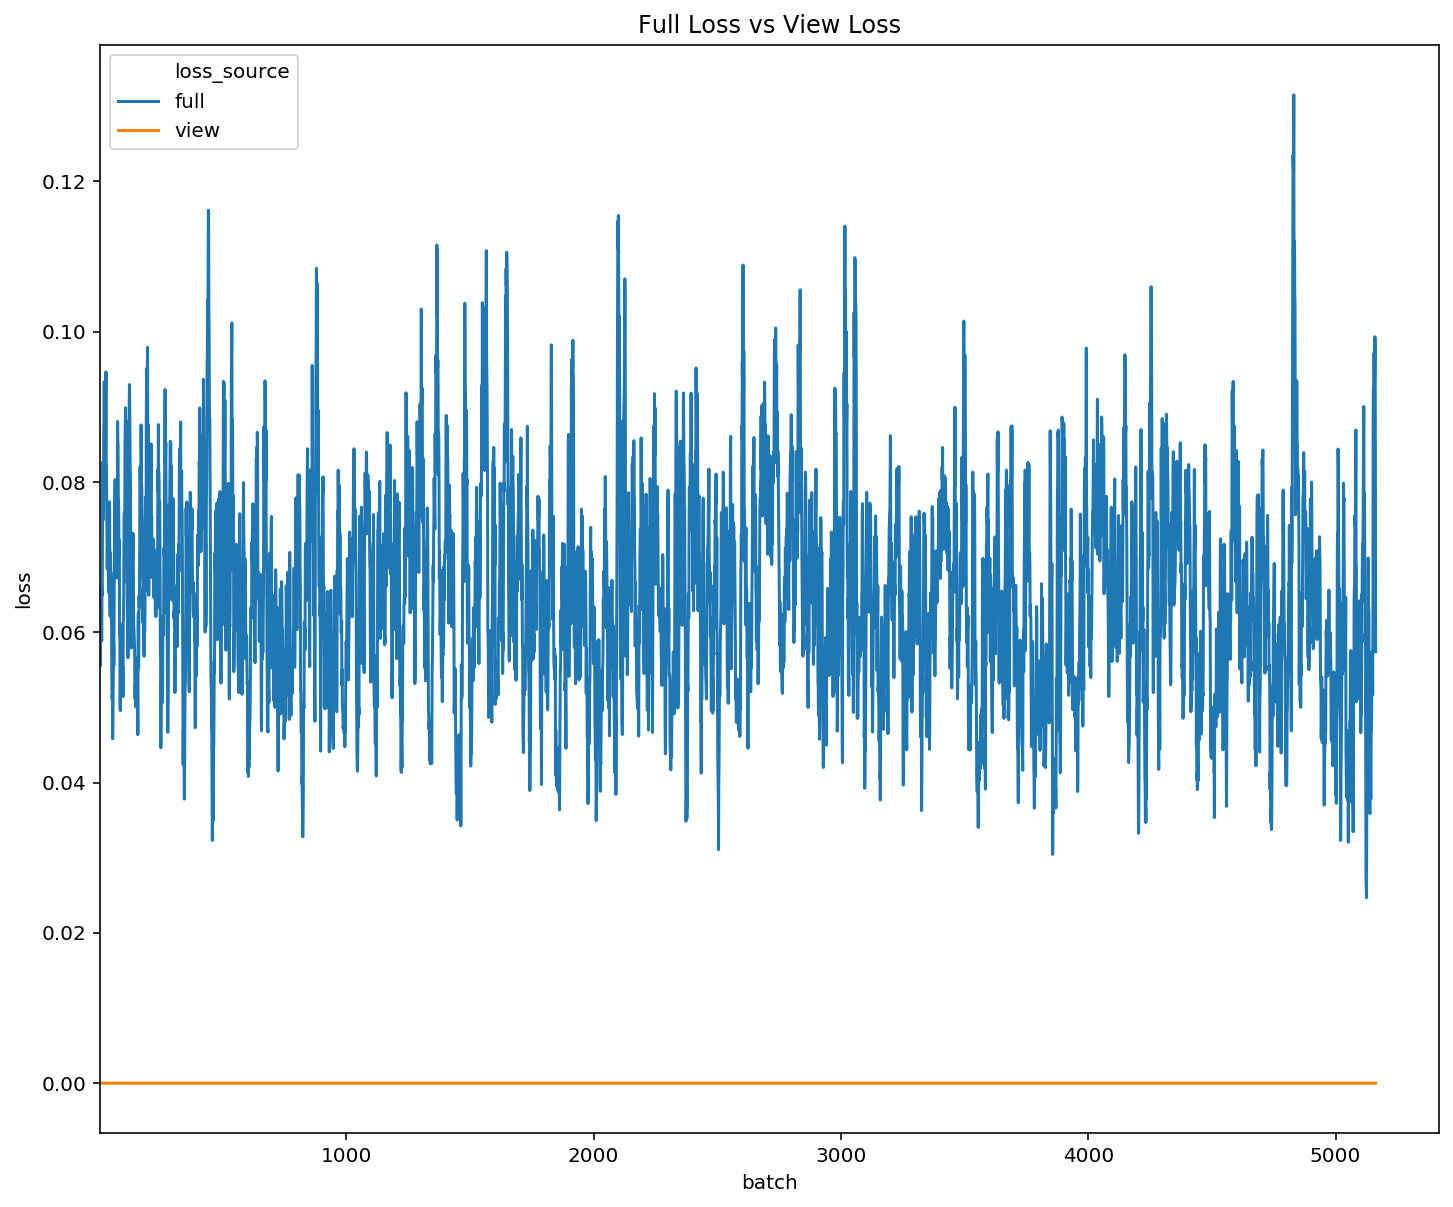

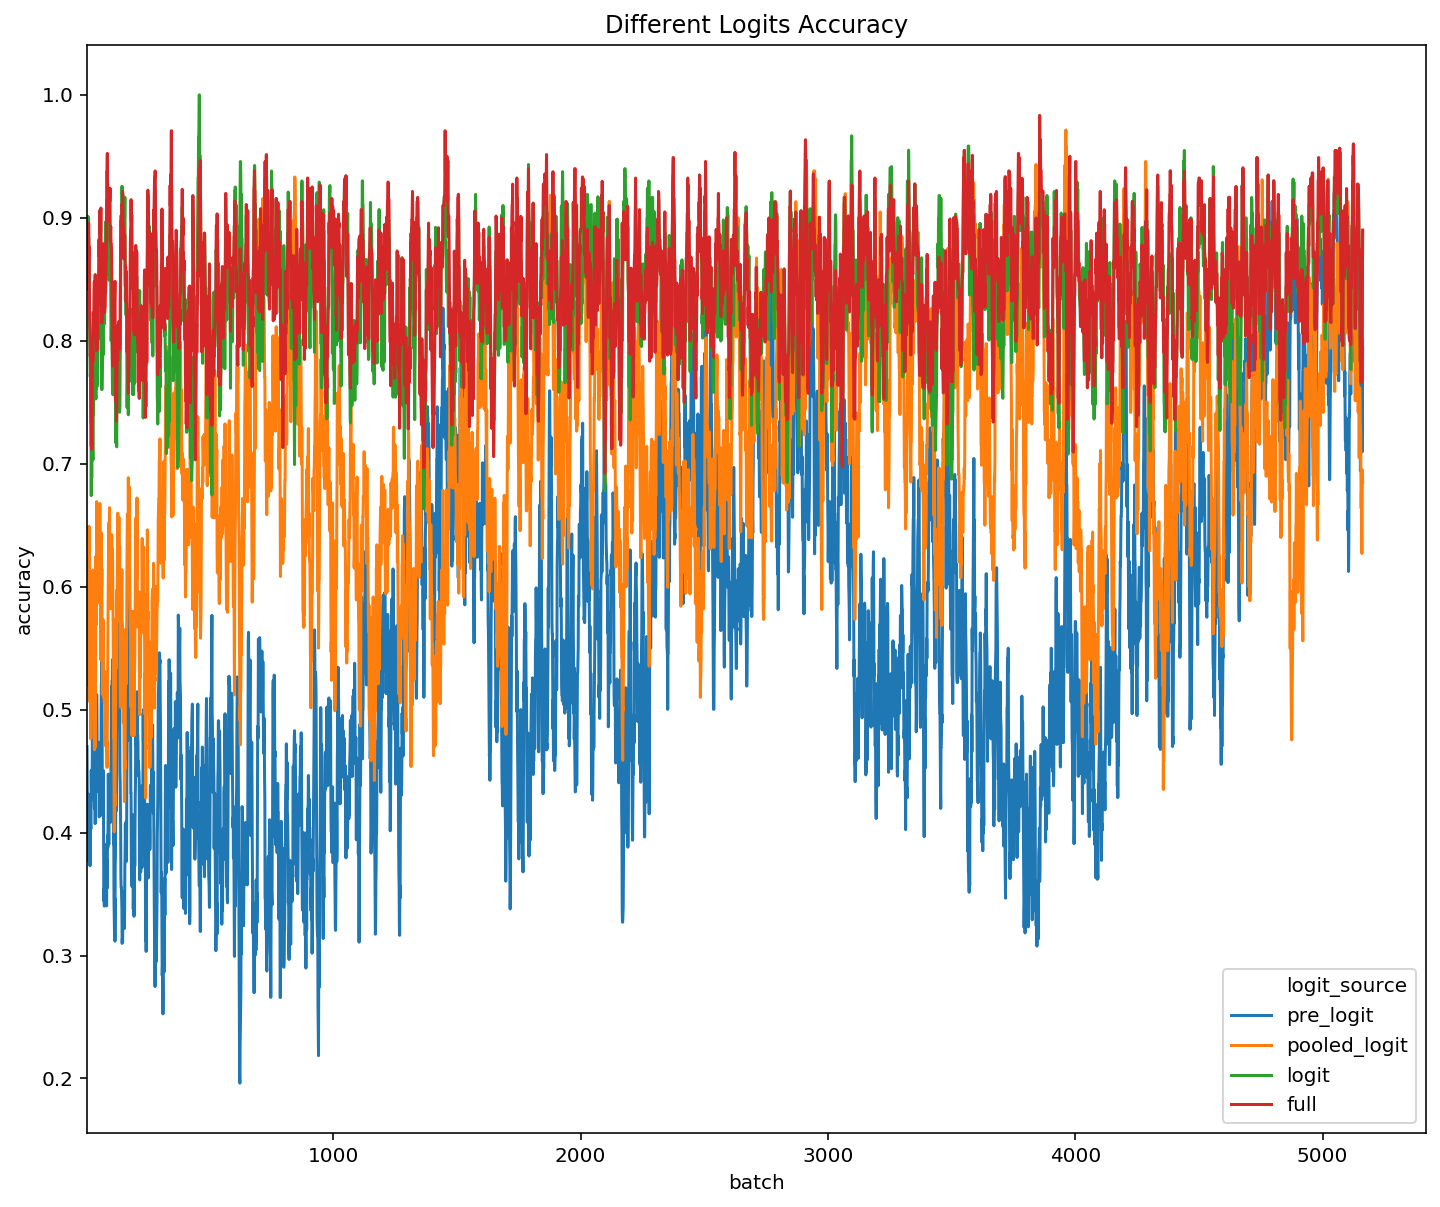

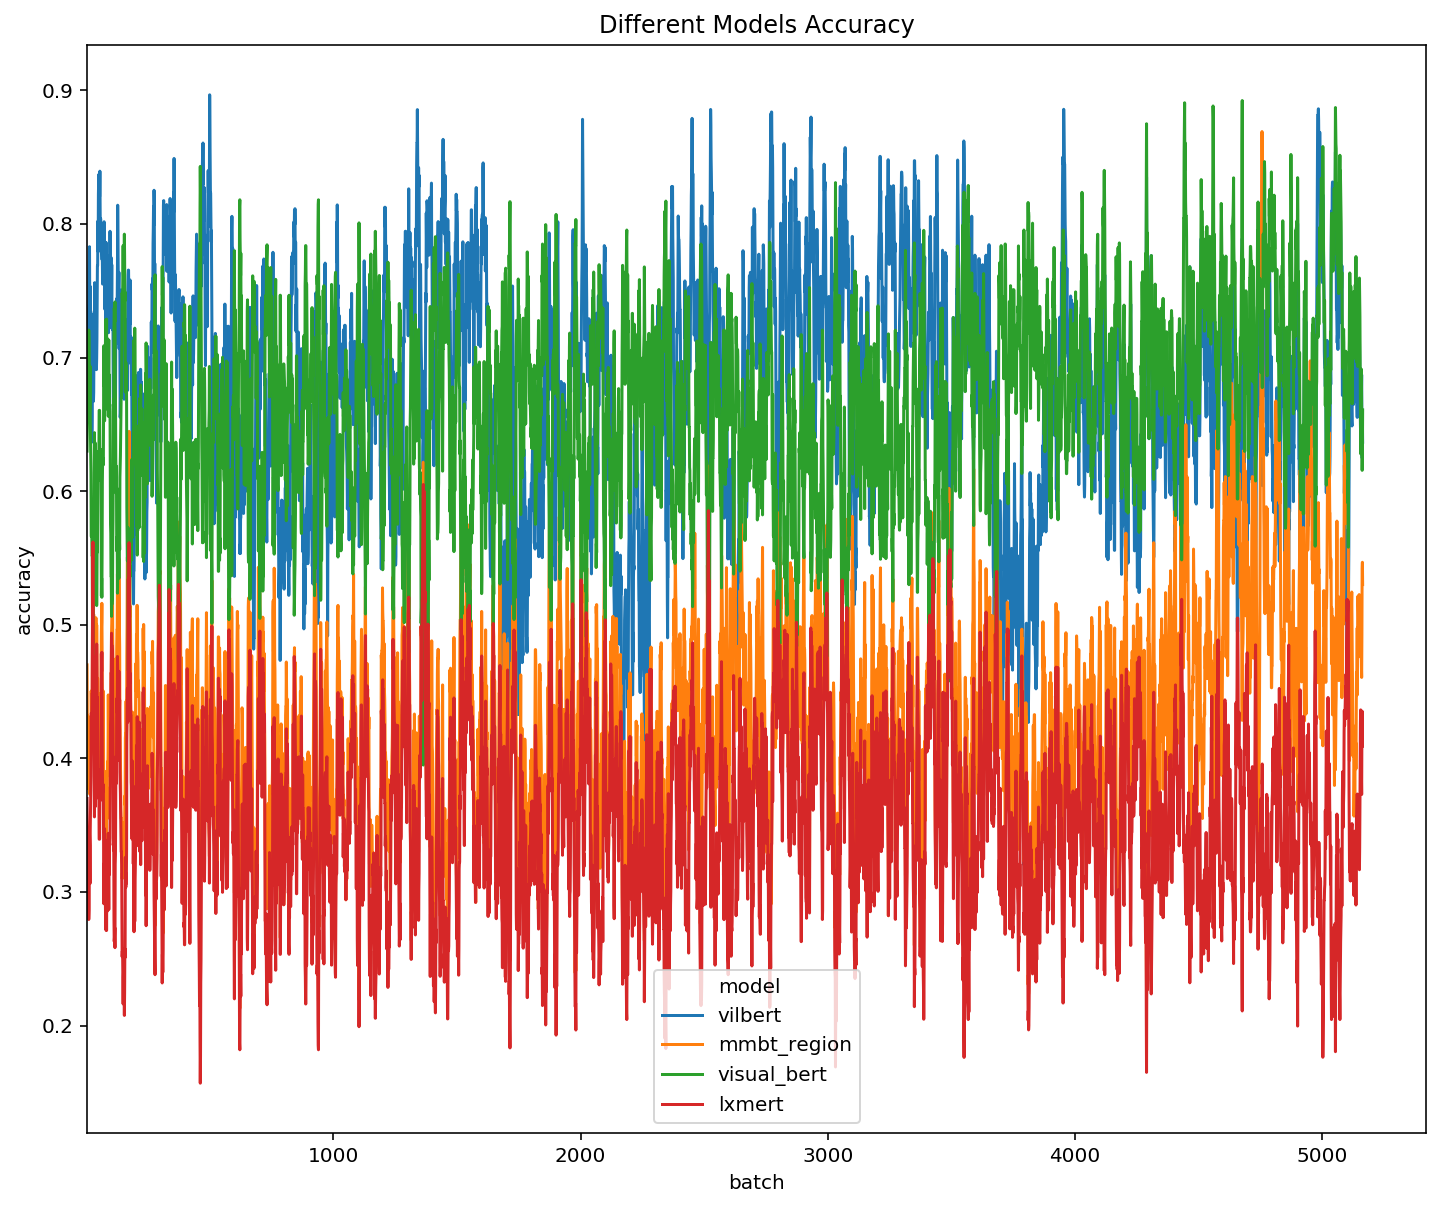

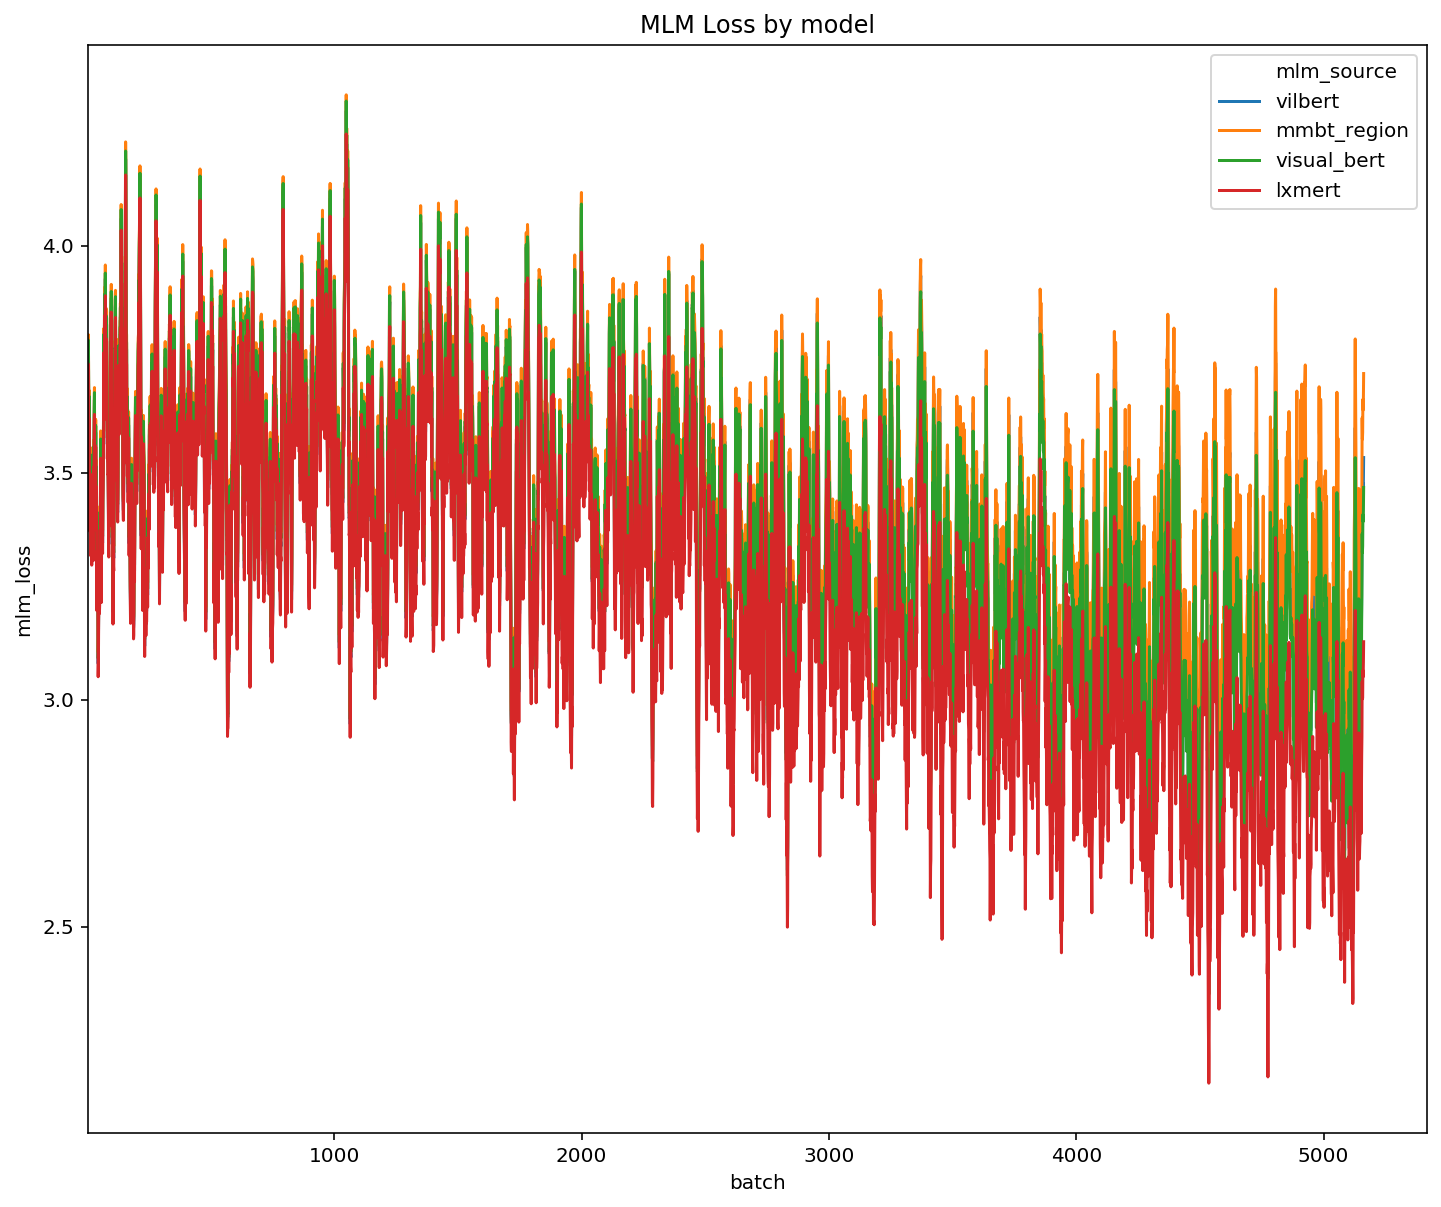

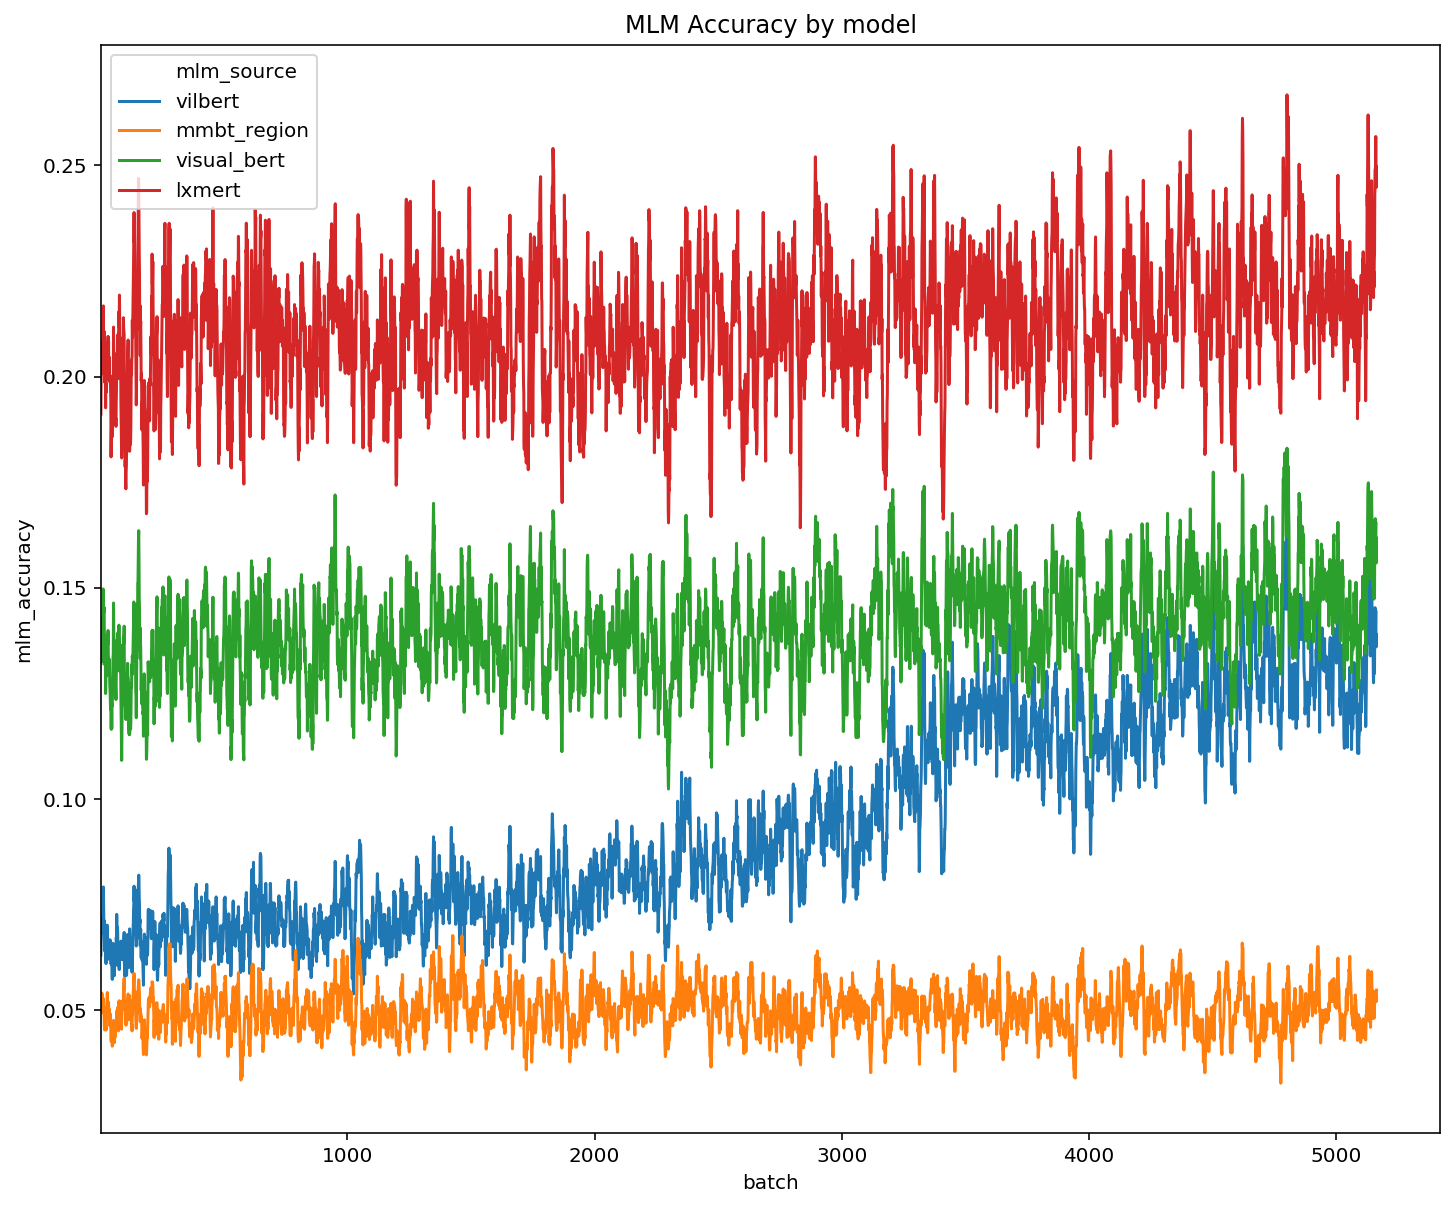

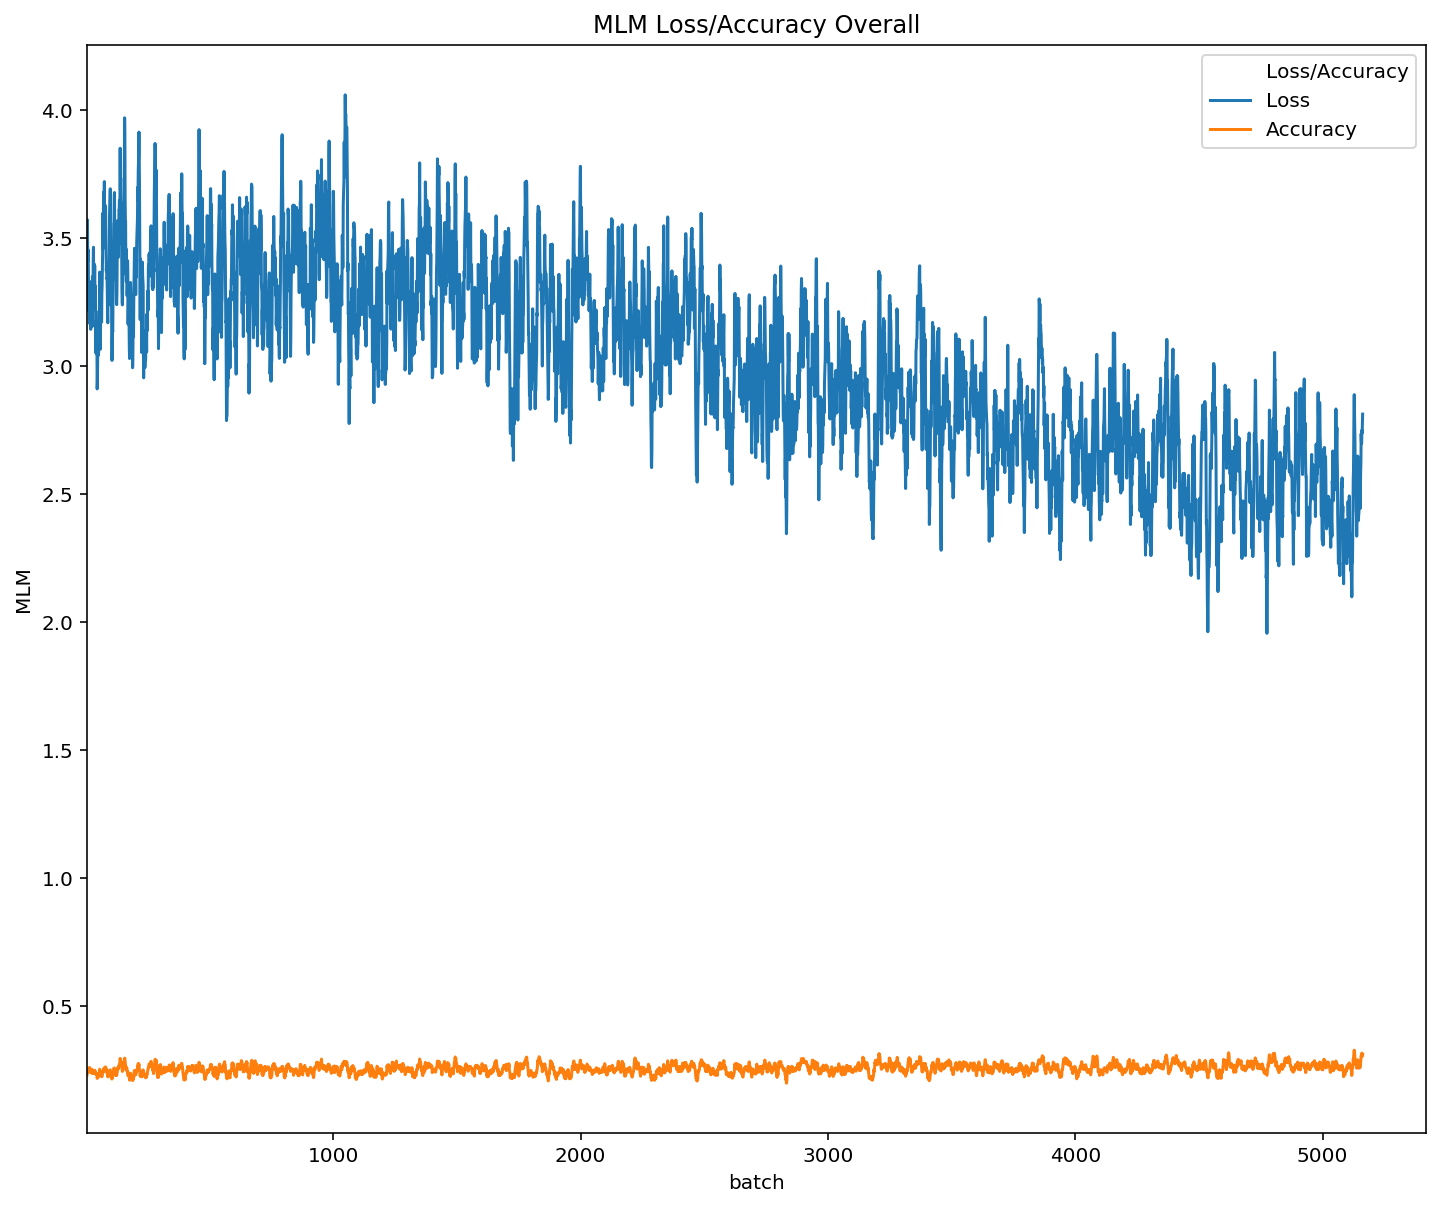

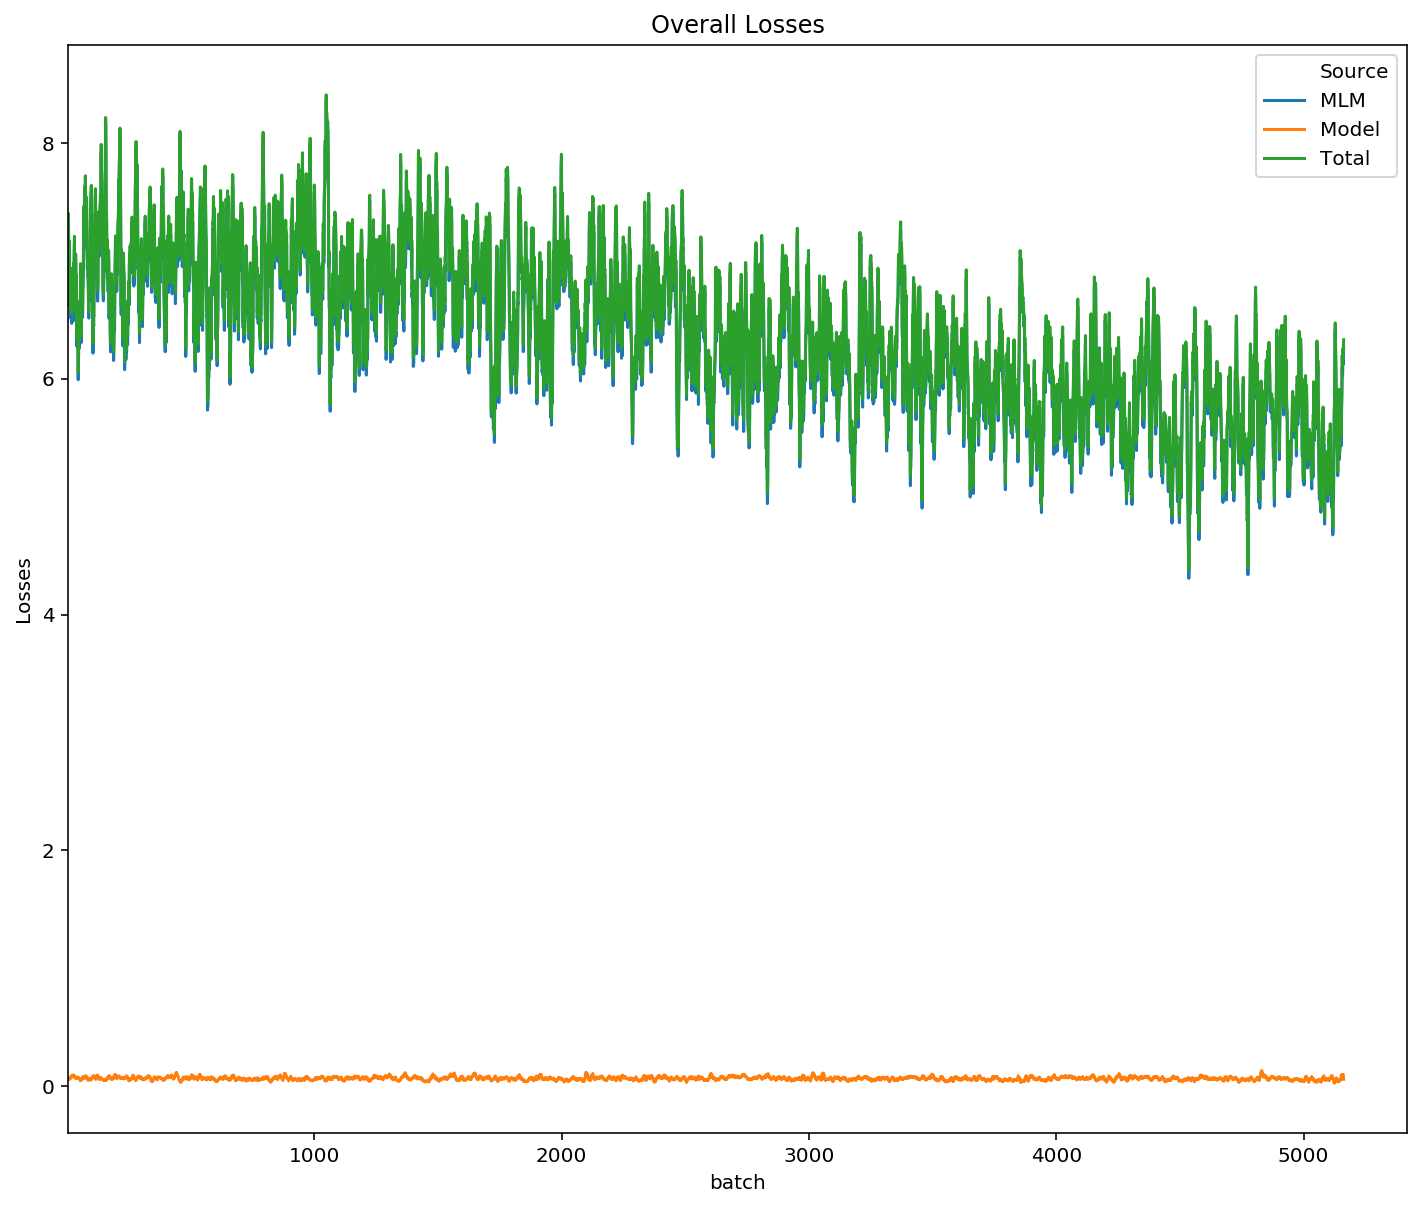

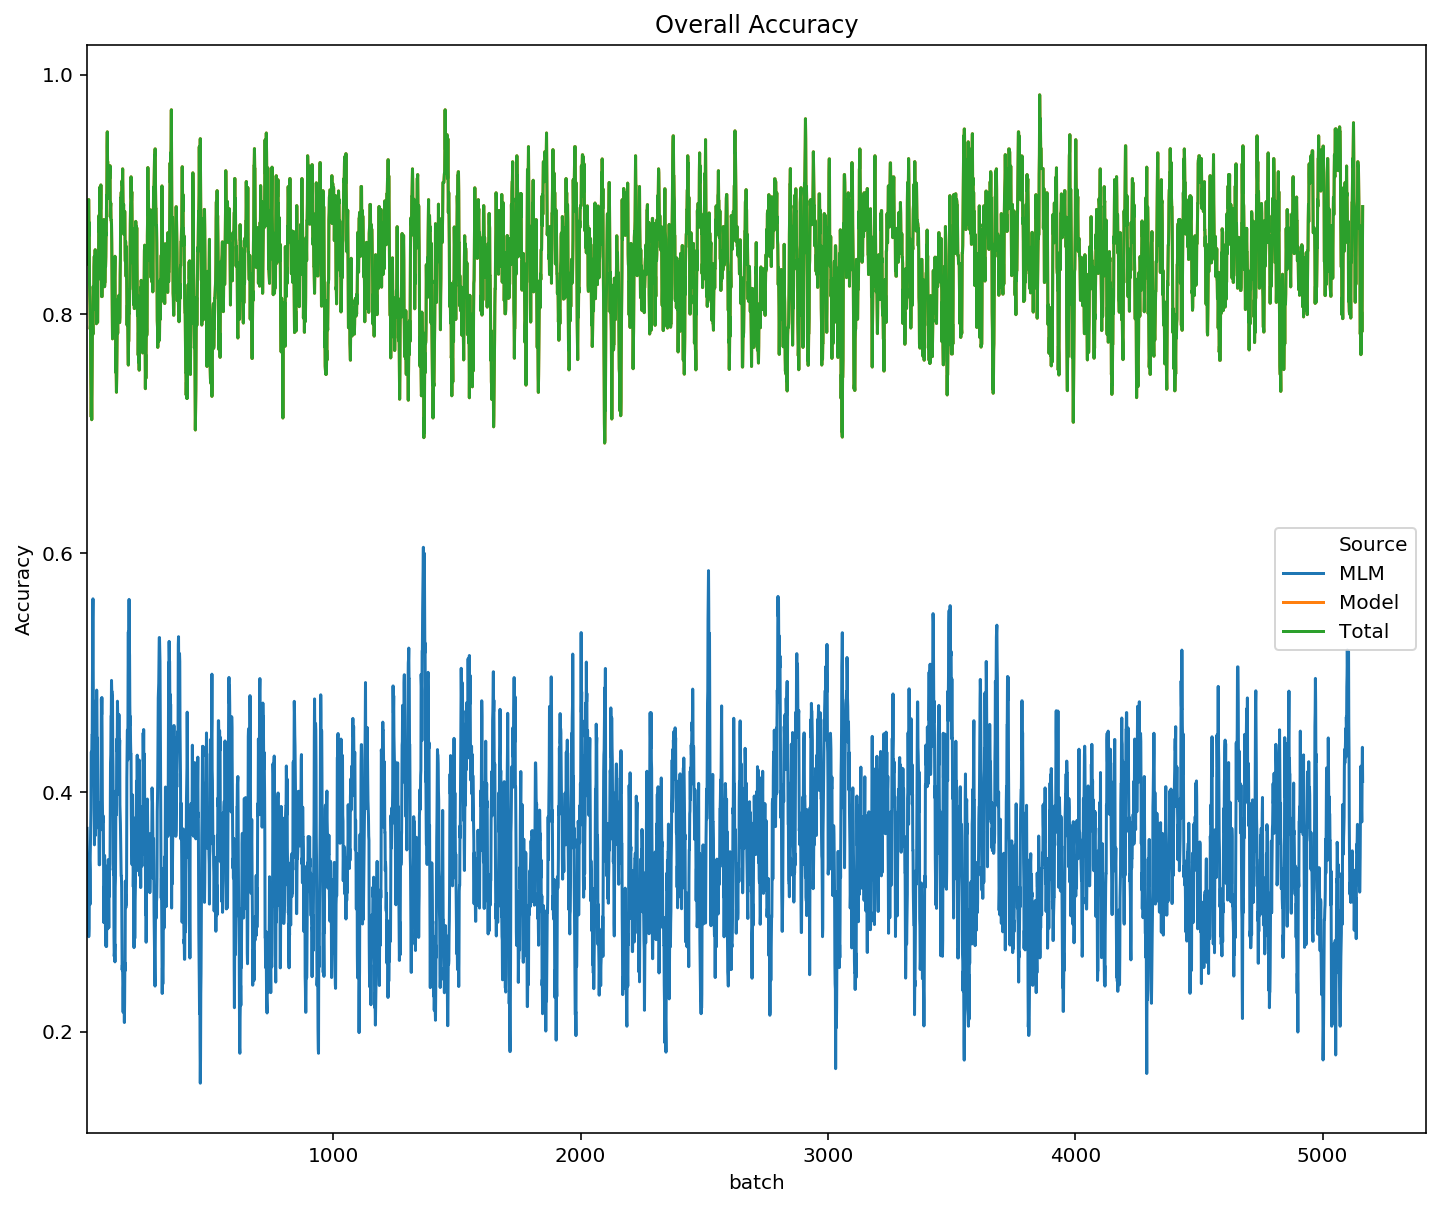

In [18]:
make_plots(model, mlm_model, logy=False, exclude_from_start=5, smoothing=10)

# Single Eval

## Validate

In [19]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True)
# scores =  {'map': '0.7743', 'acc': '0.6320', 'auc': '0.7916'}
# scores =  {'map': '0.9436', 'acc': '0.8260', 'auc': '0.9410'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.356 0.645     0   1
1      0.357 0.646     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.592,"[0.40837860107421875, 0.5916213989257812]",1,1,0.480,"[0.5203959941864014, 0.47960400581359863]",0,0,0.460,"[0.5398654341697693, 0.4601345956325531]",0,1
1,0.402,"[0.5976165533065796, 0.4023834466934204]",0,1,0.362,"[0.6376743316650391, 0.36232563853263855]",0,1,0.361,"[0.639146089553833, 0.3608538806438446]",0,0
2,0.638,"[0.36221837997436523, 0.6377816200256348]",1,1,0.620,"[0.3799493610858917, 0.6200506091117859]",1,0,0.461,"[0.5387046933174133, 0.46129533648490906]",0,0
3,0.480,"[0.5198653340339661, 0.48013466596603394]",0,0,0.592,"[0.40796270966529846, 0.5920373201370239]",1,1,0.367,"[0.6333854794502258, 0.3666144907474518]",0,1
4,0.505,"[0.4946596026420593, 0.5053404569625854]",1,1,0.621,"[0.37920522689819336, 0.6207948327064514]",1,1,0.361,"[0.6392825245857239, 0.36071741580963135]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,227,26,253.000,89.000
1,119,128,247.000,51.000
Predicted Counts,346,154,500.000,nan
Precision %,65,83,nan,nan


scores =  {'map': '0.7741', 'acc': '0.7100', 'auc': '0.7852'}


([0.7741166478479851, 0.71, 0.7851850666495976],
 (array([0.65606936, 0.83116883]),
  array([0.8972332 , 0.51821862]),
  array([0.75792988, 0.63840399]),
  array([253, 247])))

In [17]:
data = get_datasets(data_dir="/home/ahemf/cache/data/",
                    train_text_transform=preprocess_text,
                    train_image_transform=get_transforms_for_bbox_methods(),
                    test_text_transform=None,
                    test_image_transform=None,
                    train_torchvision_pre_image_transform=None,
                    test_torchvision_pre_image_transform=None,
                    cache_images=False,
                    use_images=True,
                    dev=False,
                    test_dev=True,
                    keep_original_text=True,
                    keep_original_image=True,
                    keep_processed_image=True,
                    keep_torchvision_image=False,
                    train_mixup_config=None)


In [20]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True)
# scores =  {'map': '0.8509', 'acc': '0.8426', 'auc': '0.9048'}
# scores =  {'map': '0.6208', 'acc': '0.6796', 'auc': '0.7552'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.356 0.645     0   1
1      0.357 0.645     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.575,"[0.4253878593444824, 0.5746121406555176]",1,1,0.489,"[0.5109508633613586, 0.48904916644096375]",0,1,0.441,"[0.558845043182373, 0.4411550462245941]",0,0
1,0.365,"[0.6353846788406372, 0.3646153211593628]",0,1,0.504,"[0.495781272649765, 0.5042186975479126]",1,1,0.359,"[0.6405450105667114, 0.35945504903793335]",0,0
2,0.362,"[0.6381583213806152, 0.36184167861938477]",0,0,0.361,"[0.6392262578010559, 0.3607737720012665]",0,1,0.372,"[0.6279386878013611, 0.37206128239631653]",0,0
3,0.489,"[0.5109508633613586, 0.48904916644096375]",0,1,0.591,"[0.4091354310512543, 0.5908646583557129]",1,0,0.644,"[0.35588935017585754, 0.6441106200218201]",1,1
4,0.478,"[0.5216763615608215, 0.47832363843917847]",0,0,0.627,"[0.3730776011943817, 0.6269224286079407]",1,0,0.388,"[0.6118830442428589, 0.3881170153617859]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,305,35,340.000,89.000
1,115,85,200.000,42.000
Predicted Counts,420,120,540.000,nan
Precision %,72,70,nan,nan


scores =  {'map': '0.6258', 'acc': '0.7222', 'auc': '0.7496'}


([0.6258420463341746, 0.7222222222222222, 0.7496470588235294],
 (array([0.72619048, 0.70833333]),
  array([0.89705882, 0.425     ]),
  array([0.80263158, 0.53125   ]),
  array([340, 200])))

### Higher Prediction Iters

In [21]:
clean_memory()
batch_size = 16
dev_dataset = convert_dataframe_to_dataset(data['dev_unseen'], data["metadata"], False, additional_processors=get_views())
validate(mlm_model, batch_size, dev_dataset, display_detail=True, prediction_iters=10)



Proba       Preds    
         min   max   min max
Labels                      
0      0.356 0.645     0   1
1      0.357 0.645     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.512,"[0.48804229497909546, 0.5119577050209045]",1,1,0.362,"[0.638489305973053, 0.36151066422462463]",0,0,0.379,"[0.6212949156761169, 0.3787052035331726]",0,0
1,0.360,"[0.6399377584457397, 0.3600623309612274]",0,0,0.530,"[0.4696682095527649, 0.5303317308425903]",1,1,0.445,"[0.5545891523361206, 0.4454107880592346]",0,0
2,0.423,"[0.5766329765319824, 0.4233670234680176]",0,0,0.621,"[0.3785831928253174, 0.6214166879653931]",1,1,0.602,"[0.397660493850708, 0.6023395657539368]",1,0
3,0.608,"[0.3916124999523163, 0.6083874702453613]",1,1,0.405,"[0.5952733755111694, 0.40472668409347534]",0,0,0.359,"[0.6409302353858948, 0.3590697646141052]",0,0
4,0.480,"[0.5198653936386108, 0.48013466596603394]",0,0,0.358,"[0.6416710019111633, 0.35832902789115906]",0,0,0.359,"[0.6414674520492554, 0.35853248834609985]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,305,35,340.000,89.000
1,115,85,200.000,42.000
Predicted Counts,420,120,540.000,nan
Precision %,72,70,nan,nan


scores =  {'map': '0.6258', 'acc': '0.7222', 'auc': '0.7496'}


([0.6258420463341746, 0.7222222222222222, 0.7496470588235294],
 (array([0.72619048, 0.70833333]),
  array([0.89705882, 0.425     ]),
  array([0.80263158, 0.53125   ]),
  array([340, 200])))

## Predict

In [22]:
clean_memory()
batch_size = 16
preds = predict(mlm_model, data, batch_size, competition_phase=1, prediction_iters=1)


In [26]:
preds.to_csv("submission_phase_1.csv", index=False)

In [25]:
preds["label"].value_counts()

0    712
1    288
Name: label, dtype: int64

In [26]:
clean_memory()
batch_size = 16
preds = predict(mlm_model, data, batch_size, competition_phase=2, prediction_iters=20)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
preds.to_csv("submission_phase_2.csv", index=False)

# Multi-eval
- Use back-translation
    - Longest 3 backtranslation
- Use imgaug
    - identity
    - HFlip
    - GrayScale
    - GridDrop
    
- Use word replace
    - Replace top 2 longest word
- Use `[masking]`
    - 0.15 mask rate `5` times
- identity text
    
(5+3+3)*4 = 44
